In [10]:
import os

In [11]:
from pydantic import BaseModel
import time
from typing import Literal
from itertools import batched
from rich import print
from rich.progress import track
from huggingface_hub import InferenceClient
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from tenacity import retry, stop_after_attempt, wait_exponential

In [12]:
token = os.getenv("HUGGINGFACEHUB_API_TOKEN")

In [13]:

client = InferenceClient(token=token)

In [14]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/palewire/first-llm-classifier/refs/heads/main/_notebooks/Form460ScheduleESubItem.csv"
)

In [15]:
class PayeeList(BaseModel):
    answers: list[Literal["Restaurant", "Bar", "Hotel", "Other"]]

In [16]:
@retry(stop=stop_after_attempt(3), wait=wait_exponential(min=1, max=10))
def classify_payees(name_list, model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8"):
    prompt = """
You are an AI model trained to categorize businesses based on their names.

You will be given a list of business names, each separated by a new line.

Your task is to analyze each name and classify it into one of the following categories: Restaurant, Bar, Hotel, or Other.

If a business does not clearly fall into Restaurant, Bar, or Hotel categories, you should classify it as "Other".

Even if the type of business is not immediately clear from the name, it is essential that you provide your best guess based on the information available to you. If you can't make a good guess, classify it as Other.

For example, if given the following input:

"Intercontinental Hotel\nPizza Hut\nCheers\nWelsh's Family Restaurant\nKTLA\nDirect Mailing"

Your output should be a JSON object in the following format:

{"answers": ["Hotel", "Restaurant", "Bar", "Restaurant", "Other", "Other"]}

This means that you have classified "Intercontinental Hotel" as a Hotel, "Pizza Hut" as a Restaurant, "Cheers" as a Bar, "Welsh's Family Restaurant" as a Restaurant, and both "KTLA" and "Direct Mailing" as Other.
"""


    response = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": prompt,
            },
            {
                "role": "user",
                "content": "Intercontinental Hotel\nPizza Hut\nCheers\nWelsh's Family Restaurant\nKTLA\nDirect Mailing",
            },
            {
                "role": "assistant",
                "content": '{"answers": ["Hotel", "Restaurant", "Bar", "Restaurant", "Other", "Other"]}',
            },
            {
                "role": "user",
                "content": "Subway Sandwiches\nRuth Chris Steakhouse\nPolitical Consulting Co\nThe Lamb's Club",
            },
            {
                "role": "assistant",
                "content": '{"answers": ["Restaurant", "Restaurant", "Other", "Bar"]}',
            },

{
                "role": "user",
                "content": "\n".join(name_list),
            },
        ],
        model=model,
        response_format={
            "type": "json_schema",
            "json_schema": {
                "name": "PayeeList",
                "schema": PayeeList.model_json_schema()
            }
        },
        temperature=0,
    )

    result = PayeeList.model_validate_json(response.choices[0].message.content)
    assert len(result.answers) == len(name_list), \
        f"Expected {len(name_list)} answers but got {len(result.answers)}"

    return dict(zip(name_list, result.answers))

In [17]:
sample_list = list(df.sample(10).payee)

In [19]:
classify_payees(sample_list)

{'INTERCONTINENTAL - SAN FRANCISCO': 'Hotel',
 'COALITION FOR AN INFORMED CALIFORNIA-NO ON 54': 'Other',
 'GLEN ELLEN INN RESTAURANT': 'Restaurant',
 'TODAI RESTAURANT': 'Restaurant',
 'THE MACMECHANIC': 'Other',
 'CHOPS RESTAURANT': 'Restaurant',
 'VALLARTA SUPERMARKET': 'Other',
 'SEIU UNITED LONG TERM CARE WORKERS LOCAL 6434': 'Other',
 'BOWEN FOR STATE SENATE C/O OLSON, HAGEL, ET AL.': 'Other',
 'KSOF FM': 'Other'}

In [8]:
def classify_batches(name_list, model, batch_size=10, wait=1):
    """Split the provided list of names into batches and classify with our LLM them one by one."""
    # Create a place to store the results
    all_results = {}

    # Create an list that will split the name_list into batches
    batch_list = list(batched(list(name_list), batch_size))

    # Loop through the list in batches
    for batch in track(batch_list, description="Classifying batches..."):
        # Classify it with the LLM
        batch_results = classify_payees(list(batch), model)

        # Add what we get back to the results
        all_results.update(batch_results)

        # Tap the brakes to avoid overloading Hugging Face's API
        time.sleep(wait)

    # Return the results
    return pd.DataFrame(all_results.items(), columns=["payee", "category"])

In [50]:
bigger_sample = list(df.sample(100).payee)

In [51]:
results_df = classify_batches(bigger_sample)

Output()

In [29]:
print(results_df.sample(10).reset_index(drop=True).to_markdown())

|    | payee                               | category   |
|---:|:------------------------------------|:-----------|
|  0 | PETE'S CAFE                         | Restaurant |
|  1 | ALAMO RENT-A-CAR SANTA ANA          | Other      |
|  2 | COMMITTEE TO ELECT ELENA            | Other      |
|  3 | FAIRMONT SAN JOSE                   | Hotel      |
|  4 | BEST WESTERN HOTELS SAN SIMEON      | Hotel      |
|  5 | VAROGA RICEW & SHALETT, INC.        | Other      |
|  6 | EL SEGUNDO HERALD                   | Other      |
|  7 | MCI                                 | Other      |
|  8 | TIKAL RESTAURANT                    | Restaurant |
|  9 | PEREA FOR SCCCD TRUSTEE AREA 5 2018 | Other      |

In [34]:
print(df.sample(10).reset_index().to_markdown())

|    |   index | payee                               |
|---:|--------:|:------------------------------------|
|  0 |   14901 | THE STATIONERY STUDIO               |
|  1 |    1389 | BELL WINE AND SPIRITS               |
|  2 |   10472 | NEWSOM FOR CALIFORNIA GOVERNOR 2022 |
|  3 |   11301 | PASADENA JOURNAL NEWS               |
|  4 |    3133 | CLEARMAN'S STEAK AND STEIN          |
|  5 |    4606 | EL SAUZ TACOS                       |
|  6 |    5491 | FRIENDS OF MARK TWAIN MIDDLE SCHOOL |
|  7 |    5050 | FAT CITY                            |
|  8 |   11294 | PARVINDER KANG - PETTY CASHIER      |
|  9 |   11410 | PEARL'S CAFE                        |

In [35]:
sample_df = pd.read_csv(
    "https://raw.githubusercontent.com/palewire/first-llm-classifier/refs/heads/main/_notebooks/sample.csv"
)

In [38]:
training_input, test_input, training_output, test_output = train_test_split(
    sample_df[["payee"]],
    sample_df["category"],
    test_size=0.67,
    random_state=42,  # Remember Jackie Robinson. Remember Douglas Adams.
)

In [61]:
llm_df = classify_batches(list(test_input.payee))

Output()

In [62]:
print(classification_report(test_output, llm_df.category))

precision    recall  f1-score   support

         Bar       0.25      1.00      0.40         2
       Hotel       0.90      1.00      0.95        18
       Other       0.99      0.93      0.96       112
  Restaurant       0.91      0.89      0.90        36

    accuracy                           0.93       168
   macro avg       0.76      0.95      0.80       168
weighted avg       0.96      0.93      0.94       168

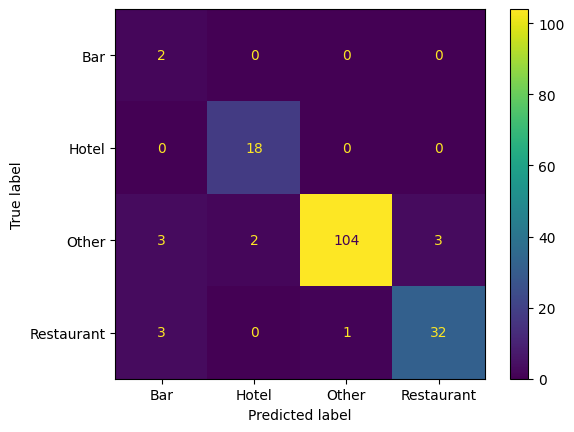

In [64]:
ConfusionMatrixDisplay.from_predictions(test_output, llm_df.category)

In [65]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [66]:
vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    min_df=5,
    norm="l2",
    encoding="latin-1",
    ngram_range=(1, 3),
)
preprocessor = ColumnTransformer(
    transformers=[("payee", vectorizer, "payee")], sparse_threshold=0, remainder="drop"
)
pipeline = Pipeline(
    [("preprocessor", preprocessor), ("classifier", LinearSVC(dual="auto"))]
)

In [67]:
model = pipeline.fit(training_input, training_output)

In [68]:
predictions = model.predict(test_input)

In [70]:
print(classification_report(test_output, predictions))

/Users/U6122976/Code/first-llm-classifier/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/U6122976/Code/first-llm-classifier/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/U6122976/Code/first-llm-classifier/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

precision    recall  f1-score   support

         Bar       0.00      0.00      0.00         2
       Hotel       0.00      0.00      0.00        18
       Other       0.67      1.00      0.80       112
  Restaurant       0.00      0.00      0.00        36

    accuracy                           0.67       168
   macro avg       0.17      0.25      0.20       168
weighted avg       0.44      0.67      0.53       168

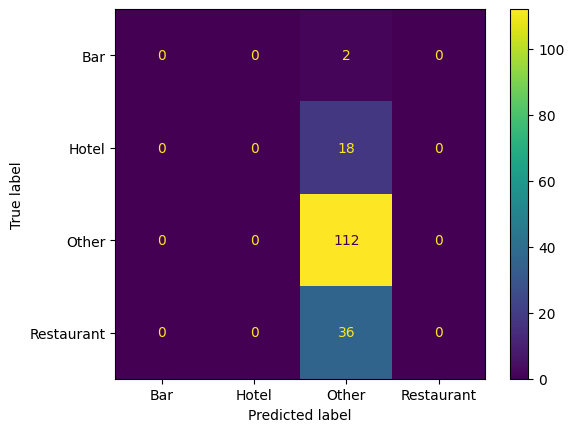

In [71]:
ConfusionMatrixDisplay.from_predictions(test_output, predictions)

In [94]:
model_list = [
    #"meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
    #"google/gemma-3-27b-it",
    "Qwen/Qwen3-235B-A22B-Instruct-2507",
]

Model: Qwen/Qwen3-235B-A22B-Instruct-2507

Output()

precision    recall  f1-score   support

         Bar       0.33      1.00      0.50         2
       Hotel       0.86      1.00      0.92        18
       Other       0.99      0.91      0.95       112
  Restaurant       0.87      0.92      0.89        36

    accuracy                           0.92       168
   macro avg       0.76      0.96      0.82       168
weighted avg       0.94      0.92      0.93       168

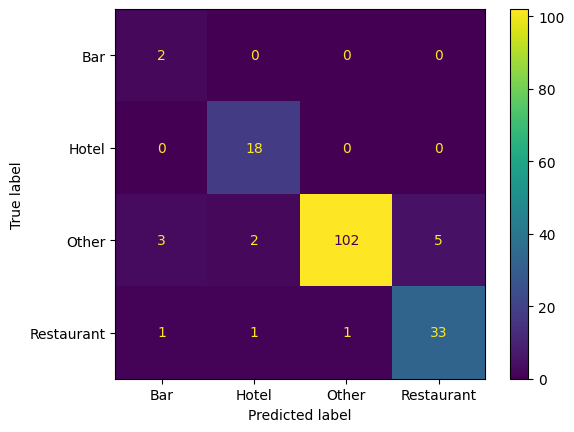

In [96]:
for m in model_list:
    print(f"Model: {m}")
    result_df = classify_batches(test_input.payee, m)
    print(classification_report(test_output, result_df.category))

In [97]:
comparison_df = llm_df.merge(
    sample_df, on="payee", how="inner", suffixes=["_llm", "_human"]
)

In [99]:
mistakes_df = comparison_df[comparison_df.category_llm != comparison_df.category_human]

In [100]:
print(mistakes_df.head(10).to_markdown())

|     | payee                            | category_llm   | category_human   |
|----:|:---------------------------------|:---------------|:-----------------|
|  16 | SOTTOVOCE MADERO                 | Restaurant     | Other            |
|  43 | SIBIA CAB                        | Bar            | Other            |
|  56 | THE OVAL ROOM                    | Bar            | Restaurant       |
|  85 | ELLA DINNING ROOM                | Restaurant     | Other            |
|  87 | LAKELAND  VILLAGE                | Hotel          | Other            |
|  95 | THE PALMS                        | Bar            | Restaurant       |
| 104 | GRUBHUB, INC.                    | Other          | Restaurant       |
| 136 | NORTHERN CALIFORNIA WINE COUNTRY | Bar            | Other            |
| 144 | MAYAHUEL                         | Bar            | Restaurant       |
| 146 | TWENTY EIGHT                     | Bar            | Other            |

In [101]:
def get_fewshots(training_input, training_output, batch_size=10):
    """Convert the training data into a few-shot prompt"""
    # Batch up the training input into groups of `batch_size`
    input_batches = list(batched(training_input.payee, batch_size))

    # Do the same for the output
    output_batches = list(batched(training_output, batch_size))

    # Create a list to hold the formatted few-shot examples
    fewshot_list = []

    # Loop through the batches
    for input_list, output_list in zip(input_batches, output_batches):
        # Create a "user" message for the LLM formatted the same was a our prompt with newlines
        prompt = "\n".join(input_list)

        # Serialize the expected "assistant" response using the Pydantic model
        response = PayeeList(answers=list(output_list)).model_dump_json()

        # Add both to the fewshot list in the format expected by our LLM
        fewshot_list.extend([
            {"role": "user", "content": prompt},
            {"role": "assistant", "content": response},
        ])

    # Return the list of few-shot examples, one for each batch
    return fewshot_list

In [102]:
fewshot_list = get_fewshots(training_input, training_output)

In [104]:
print(fewshot_list[:4])

[
    {
        'role': 'user',
        'content': 'SHERATON INN\nA1 EXECUTIVE TRANSPORTATION\nJEWISH WORLD WATCH\nCROWN COFFEE\nMARRIOTT MONTEREY 
BAY\nTWITTER\nSOMETHING SPECIAL AVIATION CATERING\nULINE SHIPPING SUPPLIES SPECIALISTS\nCOMMITTEE TO RE-ELECT 
GLORIA NEGRETE MCLEOD 2004\nPARKING NETWORK'
    },
    {
        'role': 'assistant',
        'content': 
'{"answers":["Hotel","Other","Other","Restaurant","Hotel","Other","Other","Other","Other","Other"]}'
    },
    {
        'role': 'user',
        'content': 'HILTON HOTELS COSTA MESA\nCA WOMEN LEAD\nTHE ABBEY FOOD & BAR\nALEXANDER FLORIST LLC\nRED CAR 
BREWERY\nKCBA TV\nHYATT HOTEL LAKE TAINCANE\nHILTON-SAN JOSE\nTOP NOTCH DATA, INC.\nU.S. POSTMASTER - SANTA ANA P &
DC'
    },
    {
        'role': 'assistant',
        'content': '{"answers":["Hotel","Other","Bar","Other","Bar","Other","Hotel","Hotel","Other","Other"]}'
    }
]

In [7]:
llm_df = classify_batches(
    test_input.payee,
    model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
)

NameError: name 'classify_batches' is not defined

In [111]:
print(classification_report(test_output, llm_df.category))

precision    recall  f1-score   support

         Bar       0.25      1.00      0.40         2
       Hotel       0.95      1.00      0.97        18
       Other       0.98      0.95      0.96       112
  Restaurant       0.91      0.83      0.87        36

    accuracy                           0.93       168
   macro avg       0.77      0.94      0.80       168
weighted avg       0.95      0.93      0.94       168